# Artificial Neural Network for the solution of Ordinary Differential Equations

The following code is the implementation of an Artificial Neural Network to solve ODE.

A generic ODE can be written in the form:
$$ f(t, x, x', x'', ...) = 0 $$
where $t \in [t_{min}, t_{max}]$
with boundary conditions $x(t_0) = x_0$, ...

An ANN can approximate any continuous function (Universal approzimation theorem), thus we use it to approximate $x(t)$ such that the ODE is satisfied in the interval defined above and with the corresponding boundary conditions.

For our purpose, the ANN must have 1 input, 1 output and an arbitrary number of hidden layers and hidden neurons. For semplicity purposes, we use a shallow neural network (1 hidden layer) containing $H$ neurons. We will call it $N(t|\theta)$ where $t$ is the input variable and $\theta$ are the parameters to learn.

We define a Trial function so that the boundary conditions are perfectly satisfied, independently of the choice of the parameters of the neural network. The trial function is automatically implemented for different kinds of boundary conditions. 

For example, if the BC is $x(t_0) = x_0$, the trial function will assume the form of:
$$\hat{x(t)} = x_0 + (t-t_0)N(t|\theta)$$

The algorithm learns by minimizing the loss function changing the parameters $\theta$ through classical gradient descent algorithms.

In [1]:
import torch
from torch.autograd import Variable
from torch.autograd import grad
import torch.optim as optim
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In the file "functions1d.py" there are some ODE already implemented.

Here we load:
* the differential equation (function with input $t$, $x$ and derivatives of $x$) and its degree (int)
* the interval that we want to consider (tuple)
* the boundary conditions (set of tuple)
* the real solution (if known) (function with 1 input, 1 output)

In [2]:
import functions1d as fun

which = 'p0'
# options available: p0, p1, p2, p3, p3b, new

diff_eq, degree = fun.diff_eq[which], fun.degree[which]
real = fun.real[which]
bc = fun.bc[which]
t_min, t_max = fun.interval[which]

#trial = fun.trial[which]

#### General trial function 
The trial function here is defined automatically for the following boundary problems
* $x(t_0)=x_0$
* $x(t_0)=x_0$ and $x(t_1)=x_1$
* $x(t_0)=x_0$ and $x'(t_1)=y_1$



In [3]:
def trial(f, t, bc, a=True):
    l = len(bc)
    if l == 0:
        return f(t)
    elif l == 1:
        return bc[0][1] + (t-bc[0][0])*f(t)
    elif l == 2 and a==False:
        return bc[0][1]*(t-bc[1][0])+(t-bc[0][0])*(t-bc[1][0])*f(t)+(t-bc[0][0])*bc[1][1]
    elif l == 2 and a==True:
        return bc[0][1]+(t-bc[1][0])**2*f(t)+(t-bc[0][0])*bc[1][1]
    else:
        print('error')
        return np.nan

In [4]:
D_in, H, D_out = 1, 10, 1 # number of input, of hidden neurons and output

The following function is required to evaluate the function $f(t, x, x', ...)$. 
* given the value $t_i$, it firstly calculates the value of $\hat x (t_i)$ using the trial function
* then, the needed $x'$, $x''$, ... are calculated using the autograd algorithm, and they are stored in the array gx so that $gx[0]=x'$, $gx[1]=x''$, ...
* $f(t, x, x', ...)$ is evaluated using the differential equation loaded before

In [5]:
def f(t, nn):
    x = trial(nn, t, bc)
    
    gx = []
    gx.append(grad([x], [t], grad_outputs=torch.ones(t.shape), create_graph=True)[0])
    for d in range(1, degree):
        gx.append(grad(gx[d-1], [t], grad_outputs=torch.ones(t.shape), create_graph=True)[0])
    z = diff_eq(t, x, gx)
    return z

### Training data: 
The training dataset is then created.
Since this is an unsupervised approach (the exact values of the function are not required, but used just to calculated the performance of the whole algorithm), the dataset consist only on the selection of points in the given interval that we want to use to minimize the loss function.

We chose $n\_train$ training points, equally spaced or randomly selected in the interval

In [6]:
n_train = 15
#t_train = Variable(torch.linspace(t_min, t_max, n_train).view(-1, 1), requires_grad=True)
t_train = Variable(torch.rand((n_train, 1))*(t_max-t_min)+t_min, requires_grad=True)

### Neural Network Architecture

The NN is defined here:
* seq is the architecture:
 * a Fully connected layer with D_in inputs and H outputs
 * a LogSigmoid (or Sigmoid, ReLu, ...) as the activation function
 * a Fully connected layer with H inputs and D_out outputs
* criterion is the Loss function (MSE, L1, ...)
* lr is the learning rate
* optimizer is the method to perform the gradient descent (Adam, LBFGS, ...)
* (scheduler is the method to change the learning rate)


In [7]:
seq = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    #torch.nn.ReLU(),
    #torch.nn.Sigmoid(),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(H, D_out)   
)

criterion = torch.nn.MSELoss(size_average=False)
#criterion = torch.nn.L1Loss(size_average=False)

lr = 1e-1
#optimizer = optim.Adam(seq.parameters(), lr=lr)
optimizer = optim.LBFGS(seq.parameters(), lr=lr)

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

### Training
The number of epoch is selected and the training is performed.
* the function $f(t, x, x', ...)$ is evaluated using the NN just created
* then, the loss is calculated and the error is back propagated through the network
* the closure function is needed only if the LBFGS optimizer is selected
* (the scheduler change the learning rate)
* the loss is saved and plotted

In [8]:
n_epoch = 100
Loss = []
par = np.zeros((n_epoch, 4))
for t in tqdm(range(n_epoch)): 
    y = f(t_train, seq)
    loss = criterion(y, torch.zeros(y.shape))
    optimizer.zero_grad()
    loss.backward()
    #optimizer.step()
    def closure():
        y = f(t_train, seq)
        loss = criterion(y, torch.zeros(y.shape))        
        optimizer.zero_grad()
        loss.backward()
        return loss
    optimizer.step(closure)
    #scheduler.step()
    Loss.append(loss.data.numpy())
    if np.isnan(loss.data.numpy()):
        break


100%|██████████| 100/100 [00:02<00:00, 48.14it/s]


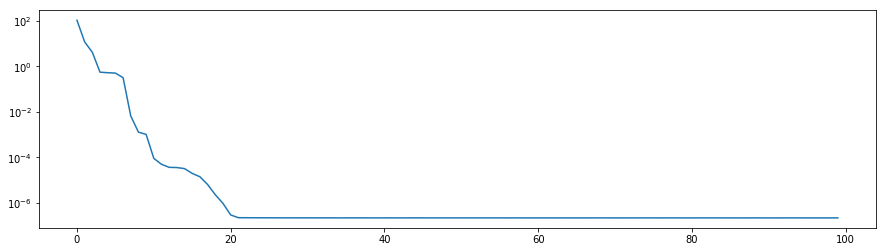

In [9]:
plt.figure(figsize=(15, 4))
plt.plot(Loss)
plt.yscale('log')
plt.show()

### Test data:
The training dataset is created selecting $n\_test$ points in the interval chosen above, equally spaced or randomly chosen

In [10]:
n_test = 100
#t_test = Variable(torch.linspace(t_min, t_max, n_test).view(-1, 1), requires_grad=True)
t_test = Variable(torch.sort(torch.rand((n_test, 1))*(t_max-t_min)+t_min, dim=0)[0], requires_grad=True)

The values of $x(t)$, the function that we have learn, and $\hat x (t)$, the function that we learned, are calculated and plotted 

In [11]:
x_real = real(t_test)
x_pred = trial(seq, t_test, bc)

x_real_train = real(t_train)
x_pred_train = trial(seq, t_train, bc)

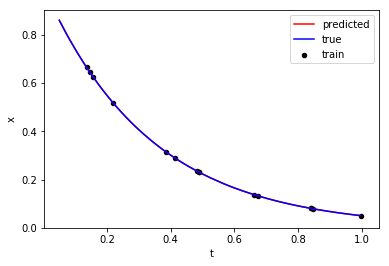

In [12]:
plt.plot(t_test.data.numpy(), x_pred.data.numpy(), label='predicted', c='r')
plt.plot(t_test.data.numpy(), x_real.data.numpy(), label='true', c='b')
plt.scatter(t_train.data.numpy(), x_real_train.data.numpy(), label='train', c='k', s=20)
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('x')
plt.show()

### Error:
To evaluate the performance, the error is calculated in the following way:
$$error = |x(t) - \hat x (t)|$$

In [13]:
error = abs(x_real-x_pred)
error_train = abs(x_real_train-x_pred_train)

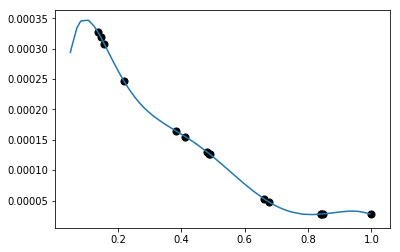

In [16]:
plt.plot(t_test.data.numpy(), error.data.numpy())
plt.scatter(t_train.data.numpy(), error_train.data.numpy(), c='k', s=50)
plt.show()

The total error is calculated as the mean of the errors in the test dataset:


In [17]:
Error = error.mean()
print(Error)

tensor(1.00000e-04 *
       1.3850)
